In [1]:
import numpy as np
import random
import os
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

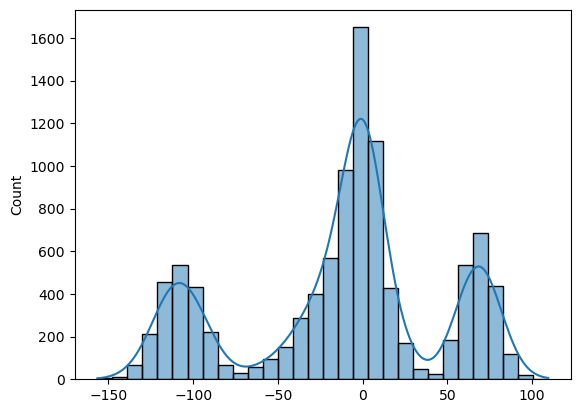

In [2]:
import numpy as np
import torch

# 生成多峰分布数据
data1 = np.random.multivariate_normal([3, 9], [[1, 0.5], [0.5, 1]], 2000)
data2 = np.random.multivariate_normal([-3, -9], [[1, 0.5], [0.5, 1]], 2000)
data3 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], 2000)
data4 = np.random.multivariate_normal([6, -6], [[1, 0.5], [0.5, 1]], 2000)
data5 = np.random.multivariate_normal([-6, 6], [[1, 0.5], [0.5, 1]], 2000)
data6 = np.vstack([data1, data2, data3, data4, data5])

coef1 = [5, 6]
coef2 = [25, -6]
coef3 = [3, 13]
coef4 = [4, 4]
coef5 = [14, -4]
noise = np.random.randn(10000)

# 生成多峰目标变量
data7_1 = data6[:2000, 0] * coef1[0] + data6[:2000, 1] * coef1[1] + noise[:2000]
data7_2 = data6[2000:4000, 0] * coef2[0] + data6[2000:4000, 1] * coef2[1] + noise[2000:4000]
data7_3 = data6[4000:6000, 0] * coef3[0] + data6[4000:6000, 1] * coef3[1] + noise[4000:6000]
data7_4 = data6[6000:8000, 0] * coef4[0] + data6[6000:8000, 1] * coef4[1] + noise[6000:8000]
data7_5 = data6[8000:, 0] * coef5[0] + data6[8000:, 1] * coef5[1] + noise[8000:]
data7 = np.concatenate([data7_1, data7_2, data7_3, data7_4, data7_5])

# 合并数据
data = np.concatenate([data6, data7.reshape(-1, 1)], axis=1)
dataset = torch.tensor(data).float()
sns.histplot(data[:,-1], kde=True, bins=30)


In [3]:
class quantile_Backbone(nn.Module):
    def __init__(self, input_dim,output_dim):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU()
        )
       
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, output_dim),
        )
    def forward(self, x):   
        x = self.linear_model1(x)
        x = self.linear_model2(x)
        return x
    def loss_fn(self, y_pred, y_true, alpha):
        return torch.mean(torch.max(alpha * (y_true - y_pred), (alpha - 1) * (y_true - y_pred)))



In [4]:
class con_Backbone(nn.Module):
    def __init__(self, n_steps, input_dim = 1,con_dim=4):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim+con_dim, 32),
            nn.ReLU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, 32)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32+con_dim, 32),
            nn.ReLU(),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, input_dim),
        )
    def forward(self, x, con_x,idx):   
        x = torch.cat((x, con_x), dim=1) 
        x = torch.cat((self.linear_model1(x)+self.embedding_layer(idx),con_x),dim = 1)
        x = self.linear_model2(x)
        return x


In [5]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim,con_dim,alpha_mix):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = con_Backbone(T, input_dim,con_dim)
        self.quantile_backbone = quantile_Backbone(con_dim,1)
        self.to(device = self.device)
        self.alpha_mix = alpha_mix  
        self.counter = 0
    def loss_fn(self, x, con_x, lambda1, alpha, idx=None, train_stage="joint"):
        '''
        Compute the loss for training.

        train_stage : "quantile" (only train quantile regression),
                    "diffusion" (only train diffusion),
                    "joint" (jointly train both).
        '''
        # 计算 quantile_output
        
        self.counter += 1
        # 根据不同的训练阶段计算损失
        quantile_output,output, epsilon, alpha_bar = self.forward(x, con_x,  idx=idx, get_target=True)

        # 计算 quantile loss
        quantile_loss = self.quantile_backbone.loss_fn(quantile_output, x, alpha)

        # 计算 diffusion loss
        ddpm_loss = (output - epsilon).square().mean()

        # 根据 train_stage 决定冻结哪一部分网络的梯度
        if train_stage == "quantile":
            # 冻结 diffusion 部分
            for param in self.backbone.parameters():
                param.requires_grad = False
            for param in self.quantile_backbone.parameters():
                param.requires_grad = True
            return lambda1 * quantile_loss

        elif train_stage == "diffusion":
            # 冻结 quantile 部分
            for param in self.quantile_backbone.parameters():
                param.requires_grad = False
            for param in self.backbone.parameters():
                param.requires_grad = True
            return ddpm_loss

        elif train_stage == "joint":
            # 两部分都更新
            for param in self.quantile_backbone.parameters():
                param.requires_grad = True
            for param in self.backbone.parameters():
                param.requires_grad = True
            
            # 在最后一次计算损失时打印 quantile_output
            return lambda1 * quantile_loss + (1-lambda1) * ddpm_loss

        else:
            raise ValueError("Invalid train_stage. Choose from ['quantile', 'diffusion', 'joint'].")


    def forward(self, x, con_x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)
        '''
        quantile_output = self.quantile_backbone(con_x)
        quantile_output = self.alpha_mix*quantile_output + (1-self.alpha_mix)*x
        if idx is None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device=self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * quantile_output + torch.sqrt(1 - used_alpha_bars) * epsilon
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device=self.device).long()
            x_tilde = quantile_output

        output = self.backbone(x_tilde, con_x, idx)

        return (quantile_output,output, epsilon, used_alpha_bars) if get_target else output
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape,con_x):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.shape = shape
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x,con_x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x,con_x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number,con_x, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        if self.shape[0]==1:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze().reshape(-1,1)
        else:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample,con_x)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.2
batch_size =64
def traincon_ddpm(model,optimizer,num_epochs,targetdim,lambda1,alpha,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            if targetdim==1:
                batch = batch.cuda()
                y1 = batch[:,-1].reshape(-1,1).cuda()
                x1 = batch[:,:-1].cuda()
            else:
                batch = batch.cuda()
                y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                x1 = batch[:,:-targetdim].cuda()
            loss = model.loss_fn(y1,x1,lambda1,alpha)
            whole_loss+=loss
            optimizer.zero_grad()
            loss = model.loss_fn(y1,x1, lambda1=1.0, alpha=alpha, train_stage="quantile")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss = model.loss_fn(y1, x1, lambda1=0.0, alpha=alpha, train_stage="diffusion")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss = model.loss_fn(y1, x1, lambda1=0.5, alpha=alpha, train_stage="joint")
            loss.backward()
            optimizer.step()

            losses.update(loss.item())
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                if targetdim==1:
                    batch = val_batch.cuda()
                    y1 = batch[:,-1].reshape(-1,1).cuda()
                    x1 = batch[:,:-1].cuda()
                else:
                    batch = val_batch.cuda()
                    y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                    x1 = batch[:,:-targetdim].cuda()
                val_loss+=model.loss_fn(y1,x1,lambda1,alpha)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train_5, X_temp_5 = train_test_split(data, test_size=0.2, random_state=42)
X_val_5, X_test_5 = train_test_split(X_temp_5, test_size=0.5, random_state=42)

X_train_5 = pd.DataFrame(X_train_5)
X_test_5 = pd.DataFrame(X_test_5)
X_val_5 = pd.DataFrame(X_val_5)
condim = X_train_5.shape[1]-1
train_data = X_train_5
val_data = X_val_5
test_data = X_test_5
X_train_5 = np.array(train_data, dtype=np.float32)
X_val_5 = np.array(val_data, dtype=np.float32)
X_test_5 = np.array(test_data, dtype=np.float32)
resultdata = pd.DataFrame()
# 设置 'Weekly_Sales' 列的值为 vaedata 中的 'Weekly_Sales' 列的值
resultdata['test'] = X_test_5[:,-1]
scatrain5 = StandardScaler()
sca_X_train_5 = scatrain5.fit_transform(X_train_5)
scaval5 = StandardScaler()
sca_X_val_5 = scaval5.fit_transform(X_val_5)
scay5 = StandardScaler()
sca_Y_train_5 = scay5.fit_transform(X_train_5[:,-1].reshape(-1,1))
scatest5 = StandardScaler()
sca_X_test_5 = scatest5.fit_transform(X_test_5)
sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=64, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=64, shuffle=True)
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50
device = torch.device('cuda')


epoch: 0, Train Loss: 0.8219, Val Loss: 0.6702
epoch: 0, find new best loss: Train Loss: 0.6702
----------
epoch: 1, find new best loss: Train Loss: 0.2639
----------
epoch: 2, find new best loss: Train Loss: 0.2143
----------
epoch: 3, find new best loss: Train Loss: 0.1710
----------
epoch: 4, find new best loss: Train Loss: 0.1557
----------
epoch: 5, find new best loss: Train Loss: 0.1325
----------
epoch: 6, find new best loss: Train Loss: 0.1236
----------
epoch: 9, find new best loss: Train Loss: 0.1023
----------
epoch: 11, find new best loss: Train Loss: 0.0880
----------
epoch: 13, find new best loss: Train Loss: 0.0711
----------
epoch: 20, Train Loss: 0.0854, Val Loss: 0.0663
epoch: 20, find new best loss: Train Loss: 0.0663
----------
epoch: 23, find new best loss: Train Loss: 0.0654
----------
epoch: 24, find new best loss: Train Loss: 0.0607
----------
epoch: 25, find new best loss: Train Loss: 0.0550
----------
Early stopping after 35 epochs
tensor([[-0.5222],
        [

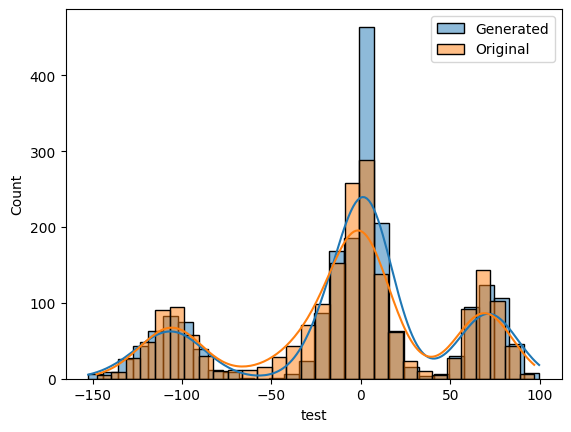

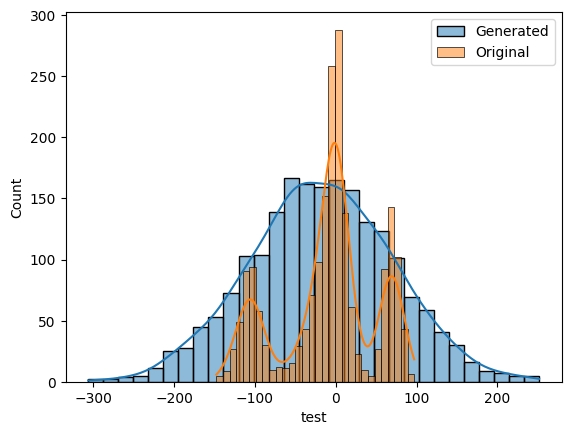

<Figure size 640x480 with 0 Axes>

In [455]:

targetdim = 1
alpha = 0.8
for i, lambda1 in enumerate(np.linspace(0.1, 1, 1)):
    if i == 10:
        break
    model = Model(device, beta_1, beta_T, T, targetdim, condim)
    optimizer = torch.optim.Adam(list(model.backbone.parameters()) + list(model.quantile_backbone.parameters()), lr=1e-3)
    traincon_ddpm(model, optimizer, 100, 1, lambda1, alpha, sca_traindata_loader_5, sca_valdata_loader_5, 10)
    model.eval()
    diffusion = DiffusionProcess(beta_1, beta_T, T, model, device, 1, condim)
    sampling_number = sca_X_test_5.shape[0]
    only_final = True
    process = DiffusionProcess(beta_1, beta_T, T, model, device, (1,),torch.Tensor(sca_X_test_5[:,:-1]).cuda())
    sample = process.sampling(sampling_number,torch.Tensor(sca_X_test_5[:,:-1]).cuda(),only_final)
    print(sample)
    trandatacvae = scay5.inverse_transform(sample.cpu().detach().numpy())
    print(trandatacvae.mean())
    tr = scay5.inverse_transform(model.quantile_backbone(torch.Tensor(sca_X_test_5[:,:-1]).cuda()).cpu().detach().numpy())
    sns.histplot(tr, kde=True, bins=30, label='Generated')
    sns.histplot(resultdata['test'], kde=True, bins=30, label='Original')
    plt.legend()  # 添加图例
    plt.show()
    sns.histplot(trandatacvae, kde=True, bins=30, label='Generated')
    sns.histplot(resultdata['test'], kde=True, bins=30, label='Original')
    plt.legend()  # 添加图例
    plt.show()
    
plt.tight_layout()
plt.show()

In [439]:
sca_X_train_5

array([[-1.5861553 ,  0.8128539 , -1.8112599 ],
       [-0.5869368 , -1.2138236 ,  0.00407175],
       [ 0.65216976,  1.293853  ,  1.4082686 ],
       ...,
       [-0.27263165,  0.1328285 ,  0.35391757],
       [ 0.9837815 ,  1.5142744 ,  1.6665918 ],
       [ 0.9636409 , -1.3369715 , -0.09315357]], dtype=float32)

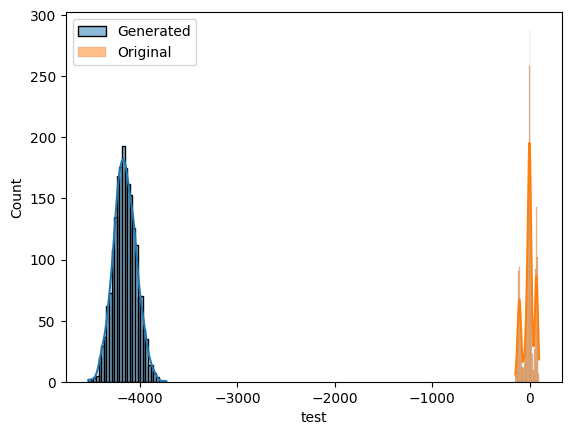

In [440]:
sampling_number = sca_X_test_5.shape[0]
only_final = True
process = DiffusionProcess(beta_1, beta_T, T, model, device, (1,),torch.Tensor(sca_X_test_5[:,:-1]).cuda())
sample = process.sampling(sampling_number,torch.Tensor(sca_X_test_5[:,:-1]).cuda(),only_final)
trandatacvae = scay5.inverse_transform(sample.cpu().detach().numpy())
sns.histplot(trandatacvae, kde=True, bins=30, label='Generated')
sns.histplot(resultdata['test'], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例

In [441]:
resultdata.mean(axis=0)

test   -9.48649
dtype: float32

pretrain

<Axes: xlabel='test', ylabel='Count'>

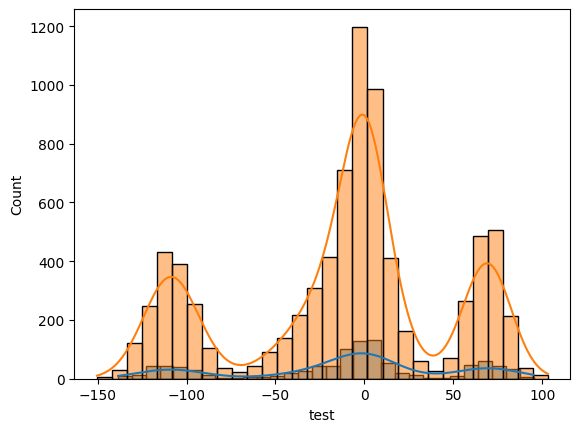

In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train_5, X_temp_5 = train_test_split(data, test_size=0.2, random_state=42)
X_val_5, X_test_5 = train_test_split(X_temp_5, test_size=0.5, random_state=42)

X_train_5 = pd.DataFrame(X_train_5)
X_test_5 = pd.DataFrame(X_test_5)
X_val_5 = pd.DataFrame(X_val_5)
condim = X_train_5.shape[1]-1
train_data = X_train_5
val_data = X_val_5
test_data = X_test_5
X_train_5 = np.array(train_data, dtype=np.float32)
X_val_5 = np.array(val_data, dtype=np.float32)
X_test_5 = np.array(test_data, dtype=np.float32)
resultdata = pd.DataFrame()
# 设置 'Weekly_Sales' 列的值为 vaedata 中的 'Weekly_Sales' 列的值
resultdata['test'] = X_test_5[:,-1]
scatrain5 = StandardScaler()
sca_X_train_5 = scatrain5.fit_transform(X_train_5)
scaval5 = StandardScaler()
sca_X_val_5 = scaval5.fit_transform(X_val_5)
scay5 = StandardScaler()
sca_Y_train_5 = scay5.fit_transform(X_train_5[:,-1].reshape(-1,1))
scatest5 = StandardScaler()
sca_X_test_5 = scatest5.fit_transform(X_test_5)
sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=64, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=64, shuffle=True)
sns.histplot(resultdata['test'], kde=True, bins=30)
sns.histplot(X_train_5[:,-1], kde=True, bins=30, label='Generated')

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 创建模型
class QuantileBackbone(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU()
        )
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
        )
    
    def forward(self, x):   
        x = self.linear_model1(x)
        x = self.linear_model2(x)
        return x

    def loss_fn(self, y_pred, y_true, alpha):
        return torch.mean(torch.max(alpha * (y_true - y_pred), (alpha - 1) * (y_true - y_pred)))

# 2. 准备数据（使用一些模拟数据作为示例）
input_dim = 2  # 假设输入特征维度为 10
output_dim = 1  # 假设输出为一个连续值（回归任务）
alpha = 0.5  # 量化回归的参数

# 模拟数据
x_train = torch.tensor(sca_X_train_5[:,:-1]).cuda()
y_train = torch.tensor(sca_Y_train_5[:,-1].reshape(-1,1)).cuda()

# 3. 初始化模型、损失函数和优化器
qmodel = QuantileBackbone(input_dim, output_dim).cuda()
optimizer = optim.Adam(qmodel.parameters(), lr=0.001)

# 4. 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    qmodel.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清零梯度
    
    # 前向传播
    y_pred = qmodel(x_train)
    
    # 计算损失
    loss = qmodel.loss_fn(y_pred, y_train, alpha)
    
    # 反向传播并更新参数
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/1000], Loss: 0.3453
Epoch [20/1000], Loss: 0.3104
Epoch [30/1000], Loss: 0.2565
Epoch [40/1000], Loss: 0.1729
Epoch [50/1000], Loss: 0.1287
Epoch [60/1000], Loss: 0.0583
Epoch [70/1000], Loss: 0.0480
Epoch [80/1000], Loss: 0.0438
Epoch [90/1000], Loss: 0.0389
Epoch [100/1000], Loss: 0.0348
Epoch [110/1000], Loss: 0.0329
Epoch [120/1000], Loss: 0.0309
Epoch [130/1000], Loss: 0.0291
Epoch [140/1000], Loss: 0.0274
Epoch [150/1000], Loss: 0.0258
Epoch [160/1000], Loss: 0.0242
Epoch [170/1000], Loss: 0.0226
Epoch [180/1000], Loss: 0.0203
Epoch [190/1000], Loss: 0.0189
Epoch [200/1000], Loss: 0.0170
Epoch [210/1000], Loss: 0.0155
Epoch [220/1000], Loss: 0.0145
Epoch [230/1000], Loss: 0.0136
Epoch [240/1000], Loss: 0.0128
Epoch [250/1000], Loss: 0.0127
Epoch [260/1000], Loss: 0.0123
Epoch [270/1000], Loss: 0.0114
Epoch [280/1000], Loss: 0.0110
Epoch [290/1000], Loss: 0.0110
Epoch [300/1000], Loss: 0.0108
Epoch [310/1000], Loss: 0.0105
Epoch [320/1000], Loss: 0.0101
Epoch [330/1000],

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


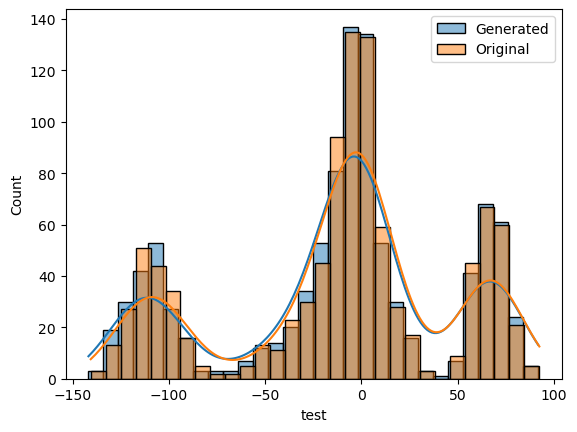

In [8]:
tr = scay5.inverse_transform(qmodel(torch.Tensor(sca_X_test_5[:,:-1]).cuda()).cpu().detach().numpy())
tr1 = scay5.inverse_transform(qmodel(torch.Tensor(sca_X_val_5[:,:-1]).cuda()).cpu().detach().numpy())
sns.histplot(tr, kde=True, bins=30, label='Generated')
sns.histplot(resultdata['test'], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例



c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


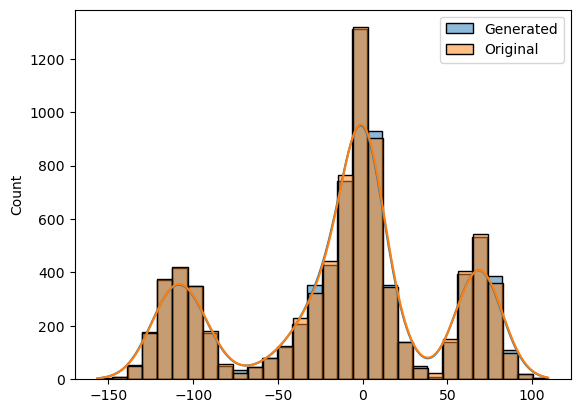

In [9]:
tr = scay5.inverse_transform(qmodel(torch.Tensor(sca_X_train_5[:,:-1]).cuda()).cpu().detach().numpy())
sns.histplot(tr, kde=True, bins=30, label='Generated')
sns.histplot(X_train_5[:,-1], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例



In [14]:
class Model(nn.Module):
    def __init__(self, trained_quantile, device, beta_1, beta_T, T, input_dim,con_dim,alpha_mix):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = con_Backbone(T, input_dim,con_dim)
        self.quantile_backbone = trained_quantile
        self.alpha_mix = alpha_mix  
        self.to(device = self.device)
        # for param in self.quantile_backbone.parameters():
        #     param.requires_grad = False
    def loss_fn(self, x, con_x, lambda1, alpha, idx=None, train_stage="joint"):
        '''
        Compute the loss for training.

        train_stage : "quantile" (only train quantile regression),
                    "diffusion" (only train diffusion),
                    "joint" (jointly train both).
        '''

        # 根据不同的训练阶段计算损失
        quantile_output,output, epsilon, alpha_bar = self.forward(x, con_x,  idx=idx, get_target=True)

        # 计算 quantile loss
        quantile_loss = self.quantile_backbone.loss_fn(quantile_output, x, alpha)

        # 计算 diffusion loss
        ddpm_loss = (output - epsilon).square().mean()

        # 根据 train_stage 决定冻结哪一部分网络的梯度
        if train_stage == "quantile":
            # 冻结 diffusion 部分
            for param in self.backbone.parameters():
                param.requires_grad = False
            for param in self.quantile_backbone.parameters():
                param.requires_grad = True
            return lambda1 * quantile_loss

        elif train_stage == "diffusion":
            # 冻结 quantile 部分
            for param in self.quantile_backbone.parameters():
                param.requires_grad = False
            for param in self.backbone.parameters():
                param.requires_grad = True
            return ddpm_loss

        elif train_stage == "joint":
            # 两部分都更新
            for param in self.quantile_backbone.parameters():
                param.requires_grad = True
            for param in self.backbone.parameters():
                param.requires_grad = True
            
            # 在最后一次计算损失时打印 quantile_output
            return lambda1 * quantile_loss + (1-lambda1) * ddpm_loss

        else:
            raise ValueError("Invalid train_stage. Choose from ['quantile', 'diffusion', 'joint'].")

    
    
    def forward(self, x,con_x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''
        quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())
        quantile_output_mixed = self.alpha_mix*quantile_output+(1-self.alpha_mix)*x
        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * quantile_output_mixed + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = quantile_output_mixed
            

            
        output = self.backbone(x_tilde,con_x, idx)
        
        return (quantile_output, output, epsilon, used_alpha_bars) if get_target else output
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape,con_x):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.shape = shape
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x,con_x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x,con_x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number,con_x, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        if self.shape[0]==1:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze().reshape(-1,1)
        else:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample,con_x)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.2
batch_size =64

In [17]:
def traincon_ddpm(model,optimizer,num_epochs,targetdim,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            if targetdim==1:
                batch = batch.cuda()
                y1 = batch[:,-1].reshape(-1,1).cuda()
                x1 = batch[:,:-1].cuda()
            else:
                batch = batch.cuda()
                y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                x1 = batch[:,:-targetdim].cuda()
            loss = model.loss_fn(y1,x1, lambda1=1.0, alpha=alpha, train_stage="quantile")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss = model.loss_fn(y1, x1, lambda1=0.0, alpha=alpha, train_stage="diffusion")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss = model.loss_fn(y1, x1, lambda1=0.5, alpha=alpha, train_stage="joint")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.update(loss.item())
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                if targetdim==1:
                    batch = val_batch.cuda()
                    y1 = batch[:,-1].reshape(-1,1).cuda()
                    x1 = batch[:,:-1].cuda()
                else:
                    batch = val_batch.cuda()
                    y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                    x1 = batch[:,:-targetdim].cuda()
                val_loss+=model.loss_fn(y1,x1,lambda1=0.5, alpha=alpha, train_stage="joint")
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

0.1


C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.3726
epoch: 0, find new best loss: Train Loss: 0.3726
----------
epoch: 1, find new best loss: Train Loss: 0.1827
----------
epoch: 2, find new best loss: Train Loss: 0.1660
----------
epoch: 3, find new best loss: Train Loss: 0.1469
----------
epoch: 4, find new best loss: Train Loss: 0.1413
----------
epoch: 5, find new best loss: Train Loss: 0.1333
----------
epoch: 6, find new best loss: Train Loss: 0.1309
----------
epoch: 7, find new best loss: Train Loss: 0.1137
----------
epoch: 9, find new best loss: Train Loss: 0.1070
----------
epoch: 10, find new best loss: Train Loss: 0.1047
----------
epoch: 11, find new best loss: Train Loss: 0.1035
----------
epoch: 12, find new best loss: Train Loss: 0.0992
----------
epoch: 13, find new best loss: Train Loss: 0.0954
----------
epoch: 14, find new best loss: Train Loss: 0.0945
----------
epoch: 16, find new best loss: Train Loss: 0.0913
----------
epoch: 18, find new best loss: Train Loss: 0.08

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.3618
epoch: 0, find new best loss: Train Loss: 0.3618
----------
epoch: 1, find new best loss: Train Loss: 0.1741
----------
epoch: 3, find new best loss: Train Loss: 0.1536
----------
epoch: 5, find new best loss: Train Loss: 0.1348
----------
epoch: 6, find new best loss: Train Loss: 0.1245
----------
epoch: 10, find new best loss: Train Loss: 0.1244
----------
epoch: 11, find new best loss: Train Loss: 0.1149
----------
epoch: 12, find new best loss: Train Loss: 0.0923
----------
epoch: 14, find new best loss: Train Loss: 0.0905
----------
epoch: 15, find new best loss: Train Loss: 0.0897
----------
epoch: 16, find new best loss: Train Loss: 0.0745
----------
epoch: 20, Train Loss: 0.0000, Val Loss: 0.0767
epoch: 22, find new best loss: Train Loss: 0.0721
----------
epoch: 24, find new best loss: Train Loss: 0.0692
----------
epoch: 29, find new best loss: Train Loss: 0.0688
----------
epoch: 32, find new best loss: Train Loss: 0.0661
------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.3742
epoch: 0, find new best loss: Train Loss: 0.3742
----------
epoch: 1, find new best loss: Train Loss: 0.1800
----------
epoch: 2, find new best loss: Train Loss: 0.1707
----------
epoch: 3, find new best loss: Train Loss: 0.1656
----------
epoch: 4, find new best loss: Train Loss: 0.1381
----------
epoch: 5, find new best loss: Train Loss: 0.1216
----------
epoch: 8, find new best loss: Train Loss: 0.1207
----------
epoch: 9, find new best loss: Train Loss: 0.1111
----------
epoch: 11, find new best loss: Train Loss: 0.0952
----------
epoch: 12, find new best loss: Train Loss: 0.0902
----------
epoch: 14, find new best loss: Train Loss: 0.0826
----------
epoch: 15, find new best loss: Train Loss: 0.0748
----------
epoch: 20, Train Loss: 0.0000, Val Loss: 0.0738
epoch: 20, find new best loss: Train Loss: 0.0738
----------
epoch: 21, find new best loss: Train Loss: 0.0668
----------
epoch: 23, find new best loss: Train Loss: 0.0647
---------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.4472
epoch: 0, find new best loss: Train Loss: 0.4472
----------
epoch: 1, find new best loss: Train Loss: 0.2134
----------
epoch: 2, find new best loss: Train Loss: 0.1862
----------
epoch: 3, find new best loss: Train Loss: 0.1576
----------
epoch: 4, find new best loss: Train Loss: 0.1529
----------
epoch: 5, find new best loss: Train Loss: 0.1239
----------
epoch: 8, find new best loss: Train Loss: 0.1179
----------
epoch: 9, find new best loss: Train Loss: 0.1060
----------
epoch: 12, find new best loss: Train Loss: 0.1025
----------
epoch: 20, Train Loss: 0.0000, Val Loss: 0.0917
epoch: 20, find new best loss: Train Loss: 0.0917
----------
epoch: 21, find new best loss: Train Loss: 0.0912
----------
epoch: 24, find new best loss: Train Loss: 0.0885
----------
epoch: 26, find new best loss: Train Loss: 0.0838
----------
epoch: 28, find new best loss: Train Loss: 0.0753
----------
epoch: 30, find new best loss: Train Loss: 0.0694
---------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.4615
epoch: 0, find new best loss: Train Loss: 0.4615
----------
epoch: 1, find new best loss: Train Loss: 0.2010
----------
epoch: 2, find new best loss: Train Loss: 0.1908
----------
epoch: 3, find new best loss: Train Loss: 0.1427
----------
epoch: 5, find new best loss: Train Loss: 0.1417
----------
epoch: 8, find new best loss: Train Loss: 0.1285
----------
epoch: 9, find new best loss: Train Loss: 0.1203
----------
epoch: 11, find new best loss: Train Loss: 0.1151
----------
epoch: 12, find new best loss: Train Loss: 0.1064
----------
epoch: 16, find new best loss: Train Loss: 0.1051
----------
epoch: 18, find new best loss: Train Loss: 0.0987
----------
epoch: 20, Train Loss: 0.0000, Val Loss: 0.0995
epoch: 21, find new best loss: Train Loss: 0.0952
----------
epoch: 22, find new best loss: Train Loss: 0.0861
----------
epoch: 28, find new best loss: Train Loss: 0.0819
----------
epoch: 29, find new best loss: Train Loss: 0.0780
--------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.3680
epoch: 0, find new best loss: Train Loss: 0.3680
----------
epoch: 1, find new best loss: Train Loss: 0.1867
----------
epoch: 2, find new best loss: Train Loss: 0.1742
----------
epoch: 3, find new best loss: Train Loss: 0.1443
----------
epoch: 6, find new best loss: Train Loss: 0.1346
----------
epoch: 7, find new best loss: Train Loss: 0.1242
----------
epoch: 8, find new best loss: Train Loss: 0.1234
----------
epoch: 9, find new best loss: Train Loss: 0.1176
----------
epoch: 11, find new best loss: Train Loss: 0.1133
----------
epoch: 15, find new best loss: Train Loss: 0.1090
----------
epoch: 17, find new best loss: Train Loss: 0.1025
----------
epoch: 19, find new best loss: Train Loss: 0.0911
----------
epoch: 20, Train Loss: 0.0000, Val Loss: 0.1045
epoch: 27, find new best loss: Train Loss: 0.0891
----------
epoch: 29, find new best loss: Train Loss: 0.0885
----------
epoch: 30, find new best loss: Train Loss: 0.0758
---------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.3661
epoch: 0, find new best loss: Train Loss: 0.3661
----------
epoch: 1, find new best loss: Train Loss: 0.2100
----------
epoch: 2, find new best loss: Train Loss: 0.1787
----------
epoch: 3, find new best loss: Train Loss: 0.1457
----------
epoch: 4, find new best loss: Train Loss: 0.1276
----------
epoch: 5, find new best loss: Train Loss: 0.1251
----------
epoch: 7, find new best loss: Train Loss: 0.1152
----------
epoch: 8, find new best loss: Train Loss: 0.1127
----------
epoch: 9, find new best loss: Train Loss: 0.1073
----------
epoch: 13, find new best loss: Train Loss: 0.0900
----------
epoch: 17, find new best loss: Train Loss: 0.0831
----------
epoch: 18, find new best loss: Train Loss: 0.0826
----------
epoch: 20, Train Loss: 0.0000, Val Loss: 0.0886
epoch: 21, find new best loss: Train Loss: 0.0821
----------
epoch: 23, find new best loss: Train Loss: 0.0778
----------
epoch: 25, find new best loss: Train Loss: 0.0644
----------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.3789
epoch: 0, find new best loss: Train Loss: 0.3789
----------
epoch: 1, find new best loss: Train Loss: 0.2080
----------
epoch: 2, find new best loss: Train Loss: 0.1798
----------
epoch: 3, find new best loss: Train Loss: 0.1521
----------
epoch: 4, find new best loss: Train Loss: 0.1420
----------
epoch: 7, find new best loss: Train Loss: 0.1207
----------
epoch: 10, find new best loss: Train Loss: 0.1015
----------
epoch: 13, find new best loss: Train Loss: 0.0970
----------
epoch: 14, find new best loss: Train Loss: 0.0903
----------
epoch: 20, Train Loss: 0.0000, Val Loss: 0.0897
epoch: 20, find new best loss: Train Loss: 0.0897
----------
epoch: 21, find new best loss: Train Loss: 0.0893
----------
epoch: 22, find new best loss: Train Loss: 0.0867
----------
epoch: 23, find new best loss: Train Loss: 0.0782
----------
epoch: 26, find new best loss: Train Loss: 0.0633
----------
epoch: 36, find new best loss: Train Loss: 0.0629
-------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.3602
epoch: 0, find new best loss: Train Loss: 0.3602
----------
epoch: 1, find new best loss: Train Loss: 0.2183
----------
epoch: 2, find new best loss: Train Loss: 0.1614
----------
epoch: 3, find new best loss: Train Loss: 0.1503
----------
epoch: 5, find new best loss: Train Loss: 0.1220
----------
epoch: 11, find new best loss: Train Loss: 0.1074
----------
epoch: 12, find new best loss: Train Loss: 0.1041
----------
epoch: 15, find new best loss: Train Loss: 0.0865
----------
epoch: 19, find new best loss: Train Loss: 0.0856
----------
epoch: 20, Train Loss: 0.0000, Val Loss: 0.0983
epoch: 23, find new best loss: Train Loss: 0.0779
----------
epoch: 29, find new best loss: Train Loss: 0.0714
----------
epoch: 31, find new best loss: Train Loss: 0.0700
----------
epoch: 33, find new best loss: Train Loss: 0.0699
----------
epoch: 36, find new best loss: Train Loss: 0.0697
----------
epoch: 38, find new best loss: Train Loss: 0.0682
------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.3431
epoch: 0, find new best loss: Train Loss: 0.3431
----------
epoch: 1, find new best loss: Train Loss: 0.2025
----------
epoch: 2, find new best loss: Train Loss: 0.1547
----------
epoch: 5, find new best loss: Train Loss: 0.1462
----------
epoch: 7, find new best loss: Train Loss: 0.1323
----------
epoch: 8, find new best loss: Train Loss: 0.1065
----------
epoch: 10, find new best loss: Train Loss: 0.1019
----------
epoch: 12, find new best loss: Train Loss: 0.0960
----------
epoch: 15, find new best loss: Train Loss: 0.0848
----------
epoch: 20, Train Loss: 0.0000, Val Loss: 0.0907
epoch: 22, find new best loss: Train Loss: 0.0674
----------
epoch: 23, find new best loss: Train Loss: 0.0657
----------
epoch: 29, find new best loss: Train Loss: 0.0629
----------
epoch: 33, find new best loss: Train Loss: 0.0528
----------
epoch: 40, Train Loss: 0.0000, Val Loss: 0.0539
Early stopping after 43 epochs


c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


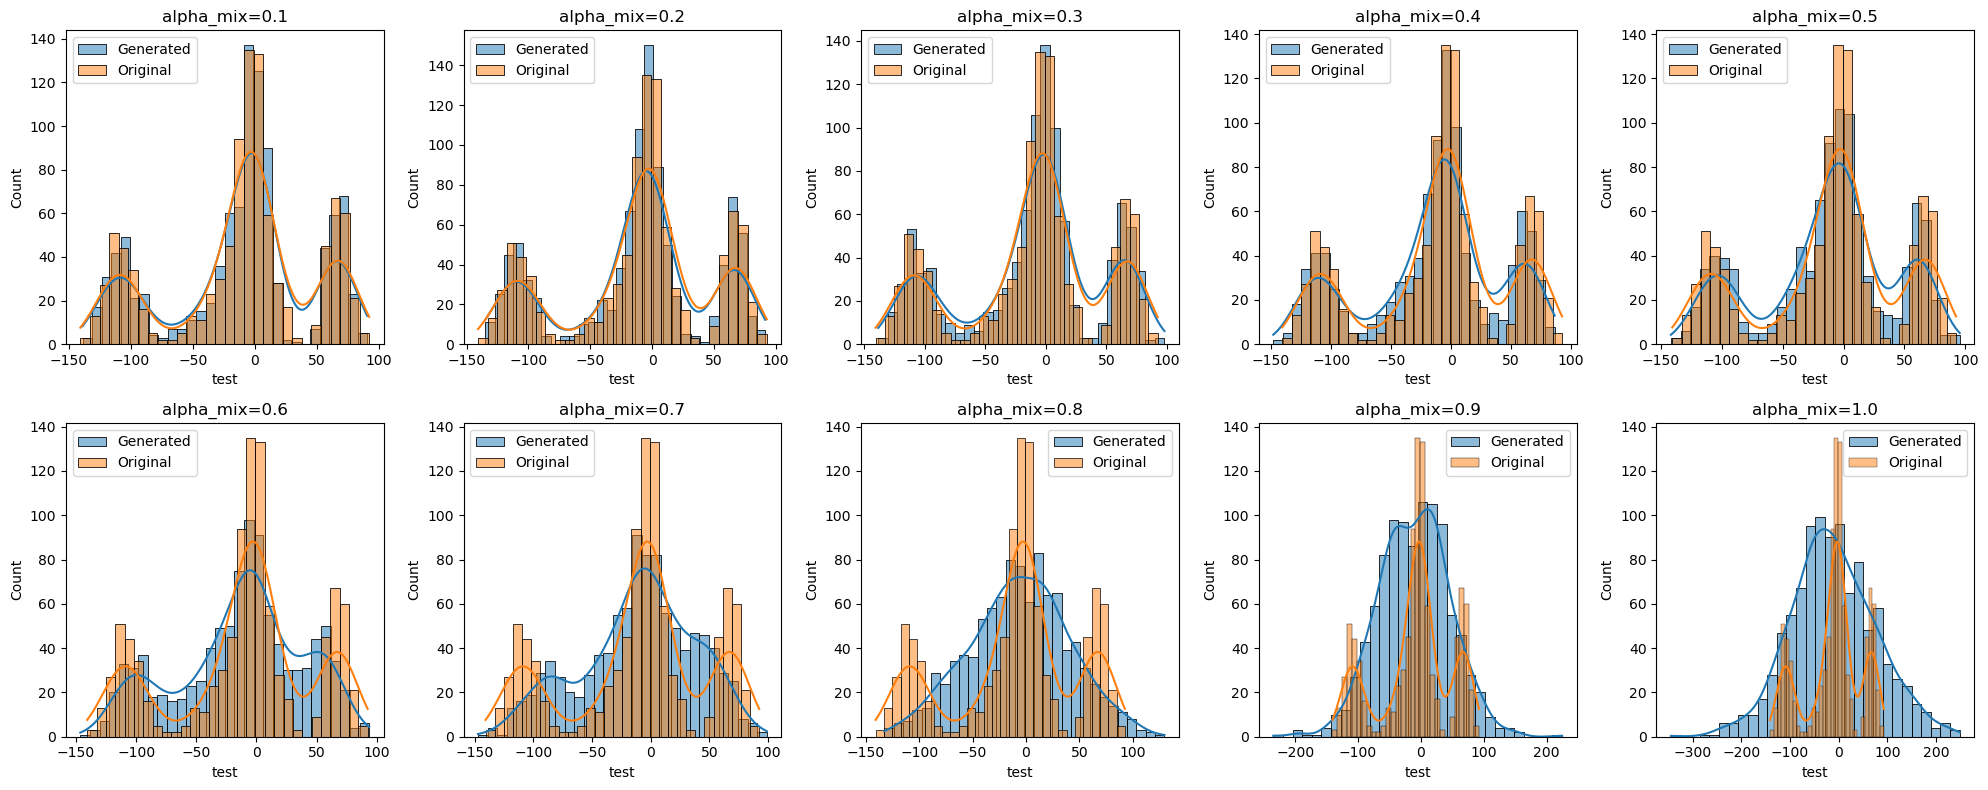

In [19]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, alpha_mix in enumerate(np.linspace(0.1, 1, 10)):
    print(alpha_mix)
    model = Model(qmodel, device, beta_1, beta_T, T, 1, condim, alpha_mix)
    optimizer = torch.optim.Adam(model.backbone.parameters(), lr=1e-3)
    traincon_ddpm(model, optimizer, 100, 1, sca_traindata_loader_5, sca_valdata_loader_5, 10)
    model.eval()
    diffusion = DiffusionProcess(beta_1, beta_T, T, model, device, 1, condim)
    sampling_number = sca_X_test_5.shape[0]
    only_final = True
    process = DiffusionProcess(beta_1, beta_T, T, model, device, (1,), torch.Tensor(sca_X_test_5[:,:-1]).cuda())
    sample = process.sampling(sampling_number, torch.Tensor(sca_X_test_5[:,:-1]).cuda(), only_final)
    trandatacvae = scay5.inverse_transform(sample.cpu().detach().numpy())
    ax = axes[i // 5, i % 5]
    sns.histplot(trandatacvae, kde=True, bins=30, label='Generated', ax=ax)
    sns.histplot(resultdata['test'], kde=True, bins=30, label='Original', ax=ax)
    ax.legend()
    ax.set_title(f'alpha_mix={alpha_mix:.1f}')

plt.tight_layout()
plt.savefig('generated_alpha_2.png')
plt.show()

C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.1877
epoch: 0, find new best loss: Train Loss: 0.1877
----------
epoch: 1, find new best loss: Train Loss: 0.1652
----------
epoch: 2, find new best loss: Train Loss: 0.1299
----------
epoch: 3, find new best loss: Train Loss: 0.1078
----------
epoch: 9, find new best loss: Train Loss: 0.0790
----------
epoch: 11, find new best loss: Train Loss: 0.0752
----------
epoch: 16, find new best loss: Train Loss: 0.0653
----------
epoch: 20, Train Loss: 0.0000, Val Loss: 0.0835
Early stopping after 26 epochs


c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


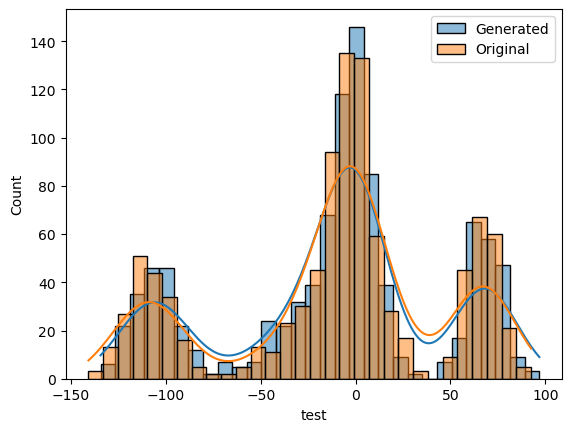

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

alpha_mix = 0.2
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50
device = torch.device('cuda')
model = Model(qmodel,device, beta_1, beta_T, T, 1,condim,alpha_mix=alpha_mix)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)
process = DiffusionProcess(beta_1, beta_T, T, model, device, 1,condim)
traincon_ddpm(model,optim,100,1,sca_traindata_loader_5,sca_valdata_loader_5,10)
sampling_number = sca_X_test_5.shape[0]
only_final = True
process = DiffusionProcess(beta_1, beta_T, T, model, device, (1,),torch.Tensor(sca_X_test_5[:,:-1]).cuda())
sample = process.sampling(sampling_number,torch.Tensor(sca_X_test_5[:,:-1]).cuda(),only_final)
trandatacvae = scay5.inverse_transform(sample.cpu().detach().numpy())
sns.histplot(trandatacvae, kde=True, bins=30, label='Generated')
sns.histplot(resultdata['test'], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例

In [99]:
class con_Backbone(nn.Module):
    def __init__(self, n_steps, input_dim = 1,con_dim=4):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim+con_dim, 32),
            nn.ReLU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, 32)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32+con_dim, 32),
            nn.ReLU(),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, input_dim),
        )
    def forward(self, x, con_x,idx):   
        x = torch.cat((x, con_x), dim=1) 
        x = torch.cat((self.linear_model1(x)+self.embedding_layer(idx),con_x),dim = 1)
        x = self.linear_model2(x)
        return x
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim,con_dim):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = con_Backbone(T, input_dim,con_dim)
        
        self.to(device = self.device)

    def loss_fn(self, x,con_x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x,con_x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss

        
    def forward(self, x,con_x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            

            
        output = self.backbone(x_tilde,con_x, idx)
        
        return (output, epsilon, used_alpha_bars) if get_target else output
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape,con_x):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.shape = shape
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x,con_x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x,con_x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number,con_x, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        if self.shape[0]==1:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze().reshape(-1,1)
        else:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample,con_x)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.2
batch_size =64
def traincon_ddpm(model,optimizer,num_epochs,targetdim,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            if targetdim==1:
                batch = batch.cuda()
                y1 = batch[:,-1].reshape(-1,1).cuda()
                x1 = batch[:,:-1].cuda()
            else:
                batch = batch.cuda()
                y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                x1 = batch[:,:-targetdim].cuda()
            loss = model.loss_fn(y1,x1)
            whole_loss+=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.update(loss.item())
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                if targetdim==1:
                    batch = val_batch.cuda()
                    y1 = batch[:,-1].reshape(-1,1).cuda()
                    x1 = batch[:,:-1].cuda()
                else:
                    batch = val_batch.cuda()
                    y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                    x1 = batch[:,:-targetdim].cuda()
                val_loss+=model.loss_fn(y1,x1)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train_5, X_temp_5 = train_test_split(data, test_size=0.2, random_state=42)
X_val_5, X_test_5 = train_test_split(X_temp_5, test_size=0.5, random_state=42)
X_train_5[:,-1] = tr.reshape(-1)
X_val_5[:,-1] = tr1.reshape(-1)
X_train_5 = pd.DataFrame(X_train_5)
X_test_5 = pd.DataFrame(X_test_5)
X_val_5 = pd.DataFrame(X_val_5)
condim = X_train_5.shape[1]-1
train_data = X_train_5
val_data = X_val_5
test_data = X_test_5
X_train_5 = np.array(train_data, dtype=np.float32)
X_val_5 = np.array(val_data, dtype=np.float32)
X_test_5 = np.array(test_data, dtype=np.float32)
resultdata = pd.DataFrame()
# 设置 'Weekly_Sales' 列的值为 vaedata 中的 'Weekly_Sales' 列的值
resultdata['test'] = X_test_5[:,-1]
scatrain5 = StandardScaler()
sca_X_train_5 = scatrain5.fit_transform(X_train_5)
scaval5 = StandardScaler()
sca_X_val_5 = scaval5.fit_transform(X_val_5)
scay5 = StandardScaler()
sca_Y_train_5 = scay5.fit_transform(X_train_5[:,-1].reshape(-1,1))
scatest5 = StandardScaler()
sca_X_test_5 = scatest5.fit_transform(X_test_5)
sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=64, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=64, shuffle=True)
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50
device = torch.device('cuda')
model = Model(device, beta_1, beta_T, T, 1,condim)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)
process = DiffusionProcess(beta_1, beta_T, T, model, device, 1,condim)
traincon_ddpm(model,optim,100,1,sca_traindata_loader_5,sca_valdata_loader_5,30)

epoch: 0, Train Loss: 0.5596, Val Loss: 0.3396
epoch: 0, find new best loss: Train Loss: 0.3396
----------
epoch: 1, find new best loss: Train Loss: 0.1926
----------
epoch: 2, find new best loss: Train Loss: 0.1418
----------
epoch: 3, find new best loss: Train Loss: 0.1346
----------
epoch: 4, find new best loss: Train Loss: 0.1313
----------
epoch: 6, find new best loss: Train Loss: 0.1095
----------
epoch: 10, find new best loss: Train Loss: 0.0959
----------
epoch: 13, find new best loss: Train Loss: 0.0836
----------
epoch: 18, find new best loss: Train Loss: 0.0836
----------
epoch: 20, Train Loss: 0.0899, Val Loss: 0.0844
epoch: 24, find new best loss: Train Loss: 0.0805
----------
epoch: 26, find new best loss: Train Loss: 0.0603
----------
epoch: 38, find new best loss: Train Loss: 0.0590
----------
epoch: 40, Train Loss: 0.0679, Val Loss: 0.0832
epoch: 48, find new best loss: Train Loss: 0.0432
----------
epoch: 60, Train Loss: 0.0491, Val Loss: 0.0644
epoch: 67, find new be

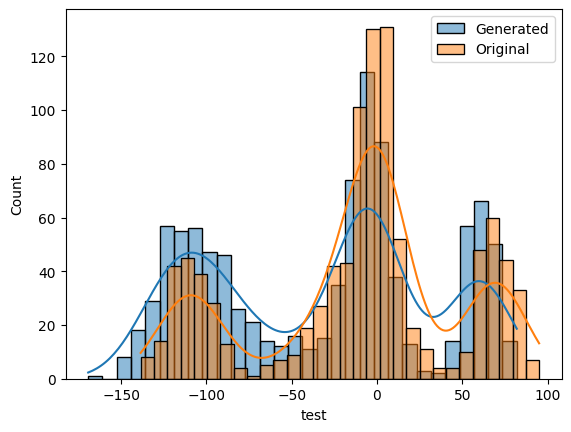

In [102]:
sampling_number = sca_X_test_5.shape[0]
only_final = True
process = DiffusionProcess(beta_1, beta_T, T, model, device, (1,),torch.Tensor(sca_X_test_5[:,:-1]).cuda())
sample = process.sampling(sampling_number,torch.Tensor(sca_X_test_5[:,:-1]).cuda(),only_final)
trandatacvae = scay5.inverse_transform(sample.cpu().detach().numpy())
sns.histplot(trandatacvae, kde=True, bins=30, label='Generated')
sns.histplot(resultdata['test'], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例